In [1]:
import numpy as np
import tensorflow as tf
from numpy import newaxis
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

In [2]:
class PPOAgent:
    def __init__(self, n_actions, n_states, n_rec_states, action_low=-1, action_high=1, reward_decay=0.99,
                 actor_learning_rate=1e-4, critic_learning_rate=2e-4, learning_rate_decay=0.95,
                 ):
        self.state_size = n_states
        self.rec_state_size = n_rec_states
        self.action_size = n_actions
        self.action_low = action_low
        self.action_high = action_high
        self.gamma = reward_decay   # discount rate
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.batch_size = 64
        self.epsilon = 0.2 # used to clip
        self.entfact = 1e-3 # entropy factor, to encourage exploration
        self.lam = 0.95 # gae factor
        self.memory = [] # store (s, a, r) for one agent
        self.agents = 5 # number of agents that collect memory
        self.history = {'states':[], 'rec_states':[], 'seqlens':[], 'actions':[], 
                       'discounted_rs':[], 'advantages':[]} # store the memory for different agents
        self._construct_nets()
        
    def _construct_nets(self):
        tf.reset_default_graph()
        self.sess = tf.Session()
        
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.tfrecs = tf.placeholder(tf.float32, [None, self.rec_state_size, 3], 'rec_state')
        self.tfseqlen = tf.placeholder(tf.int32, [None])
        
#         x_seq = tf.unstack(self.tfrecs, self.rec_state_size, axis=1)
        
#         n_rec_hidden = 32
#         lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_rec_hidden)

#         outputs, _ = tf.contrib.rnn.static_rnn(lstm_cell, x_seq, dtype=tf.float32, sequence_length=self.tfseqlen)
#         outputs = tf.stack(outputs)
#         outputs = tf.transpose(outputs, [1, 0, 2])

#         #We only want the last output for dynamic sequences
#         batch_size = tf.shape(outputs)[0]
#         index = tf.range(0, batch_size) * self.rec_state_size + (self.tfseqlen - 1)
#         outputs = tf.gather(tf.reshape(outputs, [-1, n_rec_hidden]), index) #shape is (batch_size, n_rec_hidden)
#         self.outputs = tf.concat([outputs, self.tfs], axis=1) #concat rec state and other states
        self.outputs = self.tfs

        # critic
        with tf.variable_scope('critic'):
            net = tf.layers.dense(self.outputs, 30, tf.nn.relu)
            net = tf.layers.dense(net, 30, tf.nn.relu)
            self.v = tf.layers.dense(net, 1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.closs = tf.reduce_mean(tf.square(self.tfdc_r - self.v))
            self.ctrain_op = tf.train.AdamOptimizer(self.critic_learning_rate).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        test_pi = tf.distributions.Normal(loc=pi.mean(), scale=tf.zeros_like(pi.stddev()))
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)       # choosing action
            self.sample_test = tf.squeeze(test_pi.sample(1), axis=0) # deterministic action in test
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, self.action_size], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                self.ratio = pi.prob(self.tfa) / (oldpi.prob(self.tfa)+1e-10)
                surr = self.ratio * self.tfadv
                surr2 = tf.clip_by_value(self.ratio, 1-self.epsilon, 1+self.epsilon) * self.tfadv
                self.aloss = - tf.reduce_mean(tf.minimum(surr, surr2)) - self.entfact * tf.reduce_mean(pi.entropy())

        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(self.actor_learning_rate).minimize(self.aloss, var_list=pi_params)

        self.saver = tf.train.Saver(max_to_keep=None)
        
        self.sess.run(tf.global_variables_initializer())
        
    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            net = tf.layers.dense(self.outputs, 30, tf.nn.relu, trainable=trainable)
            net = tf.layers.dense(net, 30, tf.nn.relu, trainable=trainable)
            mu = max(np.abs(self.action_low), np.abs(self.action_high)) * tf.layers.dense(net, self.action_size, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(net, self.action_size, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params
    
    def choose_action(self, state, rec_state, seqlen, train=True): # normal distribution
        dic = {self.tfs: state, self.tfrecs: rec_state, self.tfseqlen: seqlen}
        if train:
            a = self.sess.run(self.sample_op, dic)[0]
        else:
            a = self.sess.run(self.sample_test, dic)[0]
        return np.clip(a, self.action_low, self.action_high)
    
    def remember(self, state, rec_state, action, reward, seqlen):
        self.memory += [[state, rec_state, action, reward, seqlen]]
    
    def discount_rewards(self, rewards, gamma, value_next=0.0):
        discounted_r = np.zeros_like(rewards)
        running_add = value_next
        for t in reversed(range(0, len(rewards))):
            discounted_r[t] = running_add = running_add * gamma + rewards[t]
        return discounted_r
    
    def process_memory(self):
        memory = np.vstack(self.memory)
        states = np.vstack(memory[:,0])
        rec_states = np.vstack(memory[:,1])
        actions = np.vstack(memory[:,2])
        rewards = memory[:,3]
        seqlens = memory[:,4]
        discounted_ep_rs = self.discount_rewards(rewards, self.gamma)[:, newaxis]
        value_estimates = self.sess.run(self.v, {self.tfs: states, self.tfrecs: rec_states, self.tfseqlen: seqlens}).flatten()
        value_estimates = np.append(value_estimates, 0)
        delta_t = rewards + self.gamma * value_estimates[1:] - value_estimates[:-1]
        advs = self.discount_rewards(delta_t, self.gamma * self.lam)[:, newaxis] #gae
        self.history['states'] += [states]
        self.history['rec_states'] += [rec_states]
        self.history['seqlens'] += [seqlens]
        self.history['actions'] += [actions]
        self.history['discounted_rs'] += [discounted_ep_rs]
        self.history['advantages'] += [advs]
        self.memory = [] # empty the memory
    
    def replay(self):
        self.sess.run(self.update_oldpi_op)
        
        s = np.vstack(self.history['states'])
        rs = np.vstack(self.history['rec_states'])
        sl = np.concatenate(self.history['seqlens'])
        ac = np.vstack(self.history['actions'])
        dc_r = np.vstack(self.history['discounted_rs'])
        ad = np.vstack(self.history['advantages'])
        ad = (ad-ad.mean())/ad.std()
        
        for _ in range(10): # update K epochs
            s, rs, sl, ac, dc_r, ad = shuffle(s, rs, sl, ac, dc_r, ad)
            for l in range(s.shape[0]//self.batch_size):
                start = l * self.batch_size
                end = (l + 1) * self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[start:end], self.tfrecs: rs[start:end], self.tfseqlen:sl[start:end], self.tfa: ac[start:end], self.tfadv: ad[start:end]})
                self.sess.run(self.ctrain_op, {self.tfs: s[start:end], self.tfrecs: rs[start:end], self.tfseqlen:sl[start:end], self.tfdc_r: dc_r[start:end]})
            if s.shape[0] % self.batch_size != 0:
                res = s.shape[0] % self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[-res:], self.tfrecs: rs[-res:], self.tfseqlen:sl[-res:], self.tfa: ac[-res:], self.tfadv: ad[-res:]})
                self.sess.run(self.ctrain_op, {self.tfs: s[-res:], self.tfrecs: rs[-res:], self.tfseqlen:sl[-res:], self.tfdc_r: dc_r[-res:]})
        
        for key in self.history:
            self.history[key] = [] # empty the history

In [3]:
env_name = "randomSequence1_3d"
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

# Reset the environment
env_info = env.reset(train_mode=False)[default_brain]

# Examine the state space for the default brain
print("Agent's state looks like: \n{}".format(env_info.states[0]))

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 22
        Action space type: continuous
        Action space size (per agent): 4
        Memory space size (per agent): 0
        Action descriptions: 
Agent's state looks like: 
[ 1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]


In [4]:
state_n = 1
def split_state(env_info):
    seqlen = env_info.states[0][:1].astype(int)
    state = env_info.states[0][1:3*state_n+7][newaxis, :]
    rec_state = env_info.states[0][7:].reshape((1, 5, 3))
    return state, rec_state, seqlen

In [5]:
agent = PPOAgent(n_actions=4, n_states=3*state_n+6, n_rec_states=5)
rewards = []

In [6]:
# PPO
n_episodes = 500

agent.saver.restore(agent.sess, "model/drone_randomSequence1.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[default_brain]
    state, rec_state, seqlen = split_state(env_info)
    init_seqlen = seqlen
    r = 0
    while True:
        action = agent.choose_action(state, rec_state, seqlen)
        env_info = env.step(action)[default_brain]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        r += reward
        agent.remember(state, rec_state, action, reward, seqlen)
        state, rec_state, seqlen = split_state(env_info)
        if done:
            print("episode:", i_episode+1, "seqlen", init_seqlen, "rewards: %.2f" % r, end="\r")
            agent.process_memory()
            rewards += [r/init_seqlen]
            break
    if (i_episode+1) % agent.agents == 0: # update every n_agent episodes
        agent.replay()
#     if (i_episode+1) % 100 == 0:
#         agent.saver.save(agent.sess, "model/model_ppo.ckpt");
agent.saver.save(agent.sess, "model/drone_randomSequence1_3d.ckpt");
print("finished learning!")

INFO:tensorflow:Restoring parameters from model/drone_randomSequence1.ckpt


INFO:tensorflow:Restoring parameters from model/drone_randomSequence1.ckpt


INFO:tensorflow:model/drone_randomSequence1_3d.ckpt is not in all_model_checkpoint_paths. Manually adding it. 100 seqlen [1] rewards: 9.49 204 seqlen [1] rewards: 9.59 208 seqlen [1] rewards: 9.60 212 seqlen [1] rewards: 9.60 220 seqlen [1] rewards: 9.46 230 seqlen [1] rewards: 9.29 286 seqlen [1] rewards: 9.48 410 seqlen [1] rewards: 9.57 427 seqlen [1] rewards: 9.61 432 seqlen [1] rewards: 9.57 465 seqlen [1] rewards: 9.14


INFO:tensorflow:model/drone_randomSequence1_3d.ckpt is not in all_model_checkpoint_paths. Manually adding it.


finished learning!


In [9]:
n_episodes = 20

test_rewards = []
actions = []
speeds = []
angles = []
agent.saver.restore(agent.sess, "model/drone_randomSequence1_3d.ckpt")
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[default_brain]
    state, rec_state, seqlen = split_state(env_info)
    init_seqlen = seqlen
    r = 0
    while True:
        action = agent.choose_action(state, rec_state, seqlen, train=False)
        speeds += [state[0][:3]]
        angles += [state[0][3:6]]
        actions += [action]
        env_info = env.step(action)[default_brain]
        state, rec_state, seqlen = split_state(env_info)
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        r += reward
        if done:
            print("episode:", i_episode+1, "seqlen", init_seqlen, "rewards: %.2f" % r, end="\r")
            test_rewards += [r/init_seqlen]
            break
print("\n")
print("finished testing!")

INFO:tensorflow:Restoring parameters from model/drone_randomSequence1_3d.ckpt


INFO:tensorflow:Restoring parameters from model/drone_randomSequence1_3d.ckpt


episode: 20 seqlen [1] rewards: 9.63

finished testing!


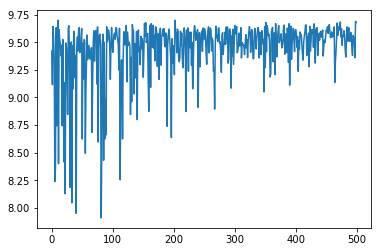

9.43638397502


In [10]:
plt.plot(rewards)
plt.show()
print(np.mean(rewards))

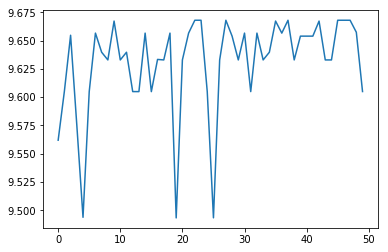

9.63075317037


In [11]:
plt.plot(test_rewards)
plt.show()
print(np.mean(test_rewards))

In [12]:
env.close()